# Predicting the Sale Price of Bulldozers using Machine Learning 

In this notebook, we'll go through an example machine learning project with the goal of predicting the sale price of bulldozers. This is a **time-series** problem as we arer trying to predict the future (forecast) by learning from the past data. This is also a **regression problem** since we're trying to predict a number.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview). The techniques used in here have been inspired and adapted from [the fast.ai machine learning course](https://course18.fast.ai/ml).

We'll work through each step and by the end of the notebook, we'll have a trained machine learning model which predicts the sale price of a bulldozer given different characteristics about it.

## 1. Problem Definition

How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data


In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, we'll want to start finding out what we can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [1]:
# Import data analysis tools 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now we've got our tools for data analysis ready, we can import the data and start to explore it.

For this project, we've downloaded the data and stored it under the notebook file path.

In [2]:
# Import the training and validation set
df = pd.read_csv("/content/TrainAndValid.csv")
df_tr = pd.read_csv("/content/Train.csv")
df_v = pd.read_csv("/content/Valid.csv")
df_te = pd.read_csv("/content/Test.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13,14,23,25,27,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.shape

(101656, 53)

In [4]:
df_tr.shape

(101656, 53)

In [5]:
df_v.shape

(11573, 52)

In [6]:
df_te.shape

(12457, 52)

In [7]:
# No parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101656 entries, 0 to 101655
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   101656 non-null  int64  
 1   SalePrice                 101656 non-null  int64  
 2   MachineID                 101656 non-null  int64  
 3   ModelID                   101656 non-null  int64  
 4   datasource                101656 non-null  int64  
 5   auctioneerID              101656 non-null  int64  
 6   YearMade                  101656 non-null  int64  
 7   MachineHoursCurrentMeter  26323 non-null   float64
 8   UsageBand                 23397 non-null   object 
 9   saledate                  101656 non-null  object 
 10  fiModelDesc               101656 non-null  object 
 11  fiBaseModel               101656 non-null  object 
 12  fiSecondaryDesc           71578 non-null   object 
 13  fiModelSeries             7540 non-null    o

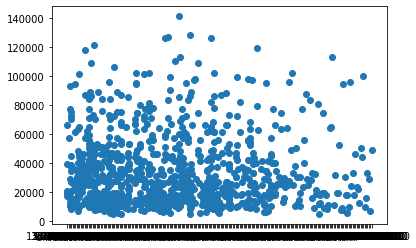

In [8]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

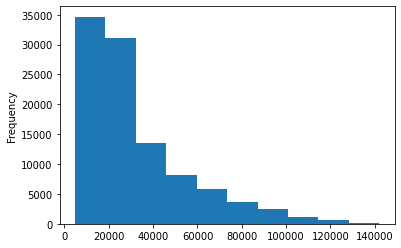

In [9]:
df.SalePrice.plot.hist()

### Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a [datetime object](https://docs.python.org/3/library/datetime.html) (a Python data type which encodes specific information about dates).

In [10]:
df = pd.read_csv("/content/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [11]:
# With parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101656 entries, 0 to 101655
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   101656 non-null  int64         
 1   SalePrice                 101656 non-null  int64         
 2   MachineID                 101656 non-null  int64         
 3   ModelID                   101656 non-null  int64         
 4   datasource                101656 non-null  int64         
 5   auctioneerID              101656 non-null  int64         
 6   YearMade                  101656 non-null  int64         
 7   MachineHoursCurrentMeter  26323 non-null   float64       
 8   UsageBand                 23397 non-null   object        
 9   saledate                  101656 non-null  datetime64[ns]
 10  fiModelDesc               101656 non-null  object        
 11  fiBaseModel               101656 non-null  object        
 12  fi

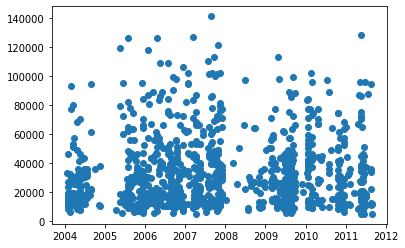

In [12]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [13]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [15]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [16]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

77792   1989-01-31
78445   1989-01-31
67034   1989-01-31
98346   1989-01-31
53101   1989-01-31
86971   1989-01-31
28927   1989-01-31
28757   1989-01-31
76171   1989-01-31
54438   1989-01-31
62755   1989-01-31
92256   1989-01-31
28820   1989-01-31
55454   1989-01-31
92803   1989-01-31
78278   1989-01-31
32317   1989-01-31
63167   1989-01-31
92833   1989-01-31
82165   1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there. This will keep the original DataFrame intact if we need it again.

In [17]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

### Add datetime parameters for saledate column

Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using `read_csv()` and we asked pandas to parse the dates using `parase_dates=["saledate"]`, we can now access the [different datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the `saledate` column.

In [18]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

We could add more of these style of columns, such as, whether it was the start or end of a quarter but these will do for now.

In [19]:
df_tmp.head().T

,77792,78445,67034,98346,53101
SalesID,1369631,1371695,1340383,1415646,1298915
SalePrice,21000,28000,110000,35000,49000
MachineID,1175092,1444477,1311130,1262088,1338785
ModelID,4146,1571,3406,3357,4124
datasource,132,132,132,132,132
auctioneerID,99,99,99,99,99
YearMade,1972,1982,1987,1975,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,D8H,D5BLGP,225B,12G,D6D


In [20]:
# Check the different values of different columns
df_tmp.state.value_counts()

Florida           14143
Texas             13346
California         6736
Georgia            3682
Washington         3295
Pennsylvania       3244
Mississippi        3178
Ohio               3098
Illinois           2941
Tennessee          2822
North Carolina     2801
New Jersey         2730
Maryland           2671
Alabama            2606
Colorado           2509
South Carolina     2285
Arizona            2196
New York           2175
Louisiana          2155
Kentucky           1860
Minnesota          1823
Missouri           1740
Nevada             1593
Maine              1531
Connecticut        1438
Indiana            1427
Unspecified        1152
Arkansas           1015
New Mexico          871
Virginia            791
Wisconsin           784
Utah                779
New Hampshire       721
Oregon              672
Wyoming             567
West Virginia       544
Idaho               540
Oklahoma            537
Iowa                432
Michigan            431
Kansas              397
Montana         

## 5. Modelling

We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model

We could spend more time doing exploratory data analysis (EDA), finding more out about the data ourselves but what we'll do instead is use a machine learning model to help us do EDA.

One of the biggest goals of starting any new machine learning project is reducing the time between experiments.

Following the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we find a [RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor) might be a good candidate.

In [21]:
# This won't work since we've got missing numbers and categories
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1)
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

ValueError: ignored

In [22]:
# Check for missing categories and different datatypes
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101656 entries, 77792 to 23971
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   101656 non-null  int64  
 1   SalePrice                 101656 non-null  int64  
 2   MachineID                 101656 non-null  int64  
 3   ModelID                   101656 non-null  int64  
 4   datasource                101656 non-null  int64  
 5   auctioneerID              101656 non-null  int64  
 6   YearMade                  101656 non-null  int64  
 7   MachineHoursCurrentMeter  26323 non-null   float64
 8   UsageBand                 23397 non-null   object 
 9   fiModelDesc               101656 non-null  object 
 10  fiBaseModel               101656 non-null  object 
 11  fiSecondaryDesc           71578 non-null   object 
 12  fiModelSeries             7540 non-null    object 
 13  fiModelDescriptor         15880 non-null 

In [23]:
# Check for missing values
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    75333
UsageBand                   78259
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc             30078
fiModelSeries               94116
fiModelDescriptor           85776
ProductSize                 58694
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                68609
Enclosure                      25
Forks                       47111
Pad_Type                    74870
Ride_Control                57200
Stick                       74870
Transmission                45808
Turbocharged                74870
Blade_Extension             95398
Blade_Width                 95398
Enclosure_Type

## Convert strings to categories

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the [pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) which allows us to interact and manipulate the types of data.

In [24]:
df_tmp.head().T

,77792,78445,67034,98346,53101
SalesID,1369631,1371695,1340383,1415646,1298915
SalePrice,21000,28000,110000,35000,49000
MachineID,1175092,1444477,1311130,1262088,1338785
ModelID,4146,1571,3406,3357,4124
datasource,132,132,132,132,132
auctioneerID,99,99,99,99,99
YearMade,1972,1982,1987,1975,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,D8H,D5BLGP,225B,12G,D6D


In [25]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [26]:
# These columns contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [27]:
# If you're wondering what df.items() does, let's use a dictionary as an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"This is a key: {key}")
    print(f"This is a value: {value}")

This is a key: key1
This is a value: hello
This is a key: key2
This is a value: world!


In [28]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [29]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101656 entries, 77792 to 23971
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   101656 non-null  int64   
 1   SalePrice                 101656 non-null  int64   
 2   MachineID                 101656 non-null  int64   
 3   ModelID                   101656 non-null  int64   
 4   datasource                101656 non-null  int64   
 5   auctioneerID              101656 non-null  int64   
 6   YearMade                  101656 non-null  int64   
 7   MachineHoursCurrentMeter  26323 non-null   float64 
 8   UsageBand                 23397 non-null   category
 9   fiModelDesc               101656 non-null  category
 10  fiBaseModel               101656 non-null  category
 11  fiSecondaryDesc           71578 non-null   category
 12  fiModelSeries             7540 non-null    category
 13  fiModelDescriptor         

In [30]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [31]:
df_tmp.state.cat.codes

77792     8
78445     8
67034     8
98346     8
53101     8
         ..
23967    10
23968     4
23972    43
23970     4
23971    43
Length: 101656, dtype: int8

All of our data is categorical and thus we can now turn the categories into numbers, however it's still missing values...

In [32]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.000000
YearMade                    0.000000
MachineHoursCurrentMeter    0.741058
UsageBand                   0.769841
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.295880
fiModelSeries               0.925828
fiModelDescriptor           0.843787
ProductSize                 0.577379
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.674913
Enclosure                   0.000246
Forks                       0.463436
Pad_Type                    0.736504
Ride_Control                0.562682
Stick                       0.736504
Transmission                0.450618
Turbocharged                0.736504
B

In the format it's in, it's still good to be worked with, let's save it to file and reimport it so we can continue on.

### Save Processed Data

In [34]:
# Save preprocessed data
df_tmp.to_csv("train_tmp.csv",
              index=False)

In [35]:
# Import preprocessed data
df_tmp = pd.read_csv("train_tmp.csv",
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1369631,1371695,1340383,1415646,1298915
SalePrice,21000,28000,110000,35000,49000
MachineID,1175092,1444477,1311130,1262088,1338785
ModelID,4146,1571,3406,3357,4124
datasource,132,132,132,132,132
auctioneerID,99,99,99,99,99
YearMade,1972,1982,1987,1975,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,D8H,D5BLGP,225B,12G,D6D


Great, our processed DataFrame has the columns we added to it but it's still missing values.

In [36]:
# Check missing values
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    75333
UsageBand                   78259
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc             30078
fiModelSeries               94116
fiModelDescriptor           85776
ProductSize                 58694
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                68609
Enclosure                      25
Forks                       47111
Pad_Type                    74870
Ride_Control                57200
Stick                       74870
Transmission                45808
Turbocharged                74870
Blade_Extension             95398
Blade_Width                 95398
Enclosure_Type

## Fill missing values

From our experience with machine learning models. We know two things:
1. All of our data has to be numerical
2. There can't be any missing values

And as we've seen using `df_tmp.isna().sum()` our data still has plenty of missing values.

Let's fill them.

### Filling numerical values first

We're going to fill any column with missing values with the median of that column.

In [37]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear


In [38]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

MachineHoursCurrentMeter


In [39]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing our not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())

Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. In other words, absence of evidence may be evidence of absence. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

In [40]:
# Check if there's any null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

### Filling and turning categorical variables to numbers

Now we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [42]:
# Check columns which *aren't* numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [43]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes+1        

In [44]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101656 entries, 0 to 101655
Columns: 102 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(45), float64(1), int16(2), int64(12), int8(42)
memory usage: 18.9 MB


In [45]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 102, dtype: int64

In [46]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1369631,1371695,1340383,1415646,1298915
SalePrice,21000,28000,110000,35000,49000
MachineID,1175092,1444477,1311130,1262088,1338785
ModelID,4146,1571,3406,3357,4124
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,False,True,True,False
Blade_Type_is_missing,False,False,True,True,False
Travel_Controls_is_missing,False,False,True,True,False
Differential_Type_is_missing,True,True,True,True,True


Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

In [47]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

CPU times: user 3min 46s, sys: 792 ms, total: 3min 47s
Wall time: 2min 2s


In [48]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

0.9882189807881863

### Splitting data into train/valid sets

In [49]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1369631,21000,1175092,4146,132,99,1972,2615.0,0,1422,...,True,True,True,True,True,False,False,False,True,True
1,1371695,28000,1444477,1571,132,99,1982,2615.0,0,1313,...,True,True,True,True,True,False,False,False,True,True
2,1340383,110000,1311130,3406,132,99,1987,2615.0,0,205,...,False,False,False,False,False,True,True,True,True,True
3,1415646,35000,1262088,3357,132,99,1975,2615.0,0,50,...,True,True,True,True,True,True,True,True,True,True
4,1298915,49000,1338785,4124,132,99,1984,2615.0,0,1363,...,True,True,True,True,True,False,False,False,True,True


According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates. This makes sense since we're working on a time series problem. E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like `train_test_split()` wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In [50]:
df_tmp.saleYear.value_counts()

2006    7315
2005    7240
2004    6897
2009    6096
2001    5937
2011    5858
2002    5641
2010    5611
2000    5470
2003    4825
2008    4542
2007    4504
1998    4114
1999    3880
1995    3264
1996    3192
1997    3156
1994    3118
1993    2615
1992    2297
1991    2254
1989    1964
1990    1866
Name: saleYear, dtype: int64

In [85]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2006]
df_train = df_tmp[df_tmp.saleYear !=2006]
#df_test = df_tmp[df_tmp.saleYear == 2006]

len(df_val), len(df_train)

(7315, 94341)

In [86]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((94341, 101), (94341,), (7315, 101), (7315,))

### Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

In [87]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

Retraing an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

If you're experiments are taking longer than 10-seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [88]:
# This takes too long...

# %%time
# # Retrain a model on training data
# model.fit(X_train, y_train)
# show_scores(model)

In [89]:
len(X_train)

94341

Let's alter the number of samples each `n_estimator` in the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) see's using the `max_samples` parameter.

In [63]:
# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000)

Setting `max_samples` to 10000 means every `n_estimator` (default 100) in our `RandomForestRegressor` will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [64]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

CPU times: user 34.4 s, sys: 219 ms, total: 34.6 s
Wall time: 18.8 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [65]:
show_scores(model)

{'Training MAE': 4465.283749695254,
 'Training RMSLE': 0.2053045050740893,
 'Training R^2': 0.9121811331142887,
 'Valid MAE': 5616.818488038277,
 'Valid RMSLE': 0.22908569119303482,
 'Valid R^2': 0.8871420145746783}

Great, now it took far less time than the model with all the data.

With this, let's try tune some hyperparameters.

### Hyperparameter tuning with RandomizedSearchCV

You can increase `n_iter` to try more combinations of hyperparameters but in our case, we'll try 20 and see where it gets us.

Remember, we're trying to reduce the amount of time it takes between experiments.

In [66]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 3min 23s, sys: 1.73 s, total: 3min 25s
Wall time: 3min 26s


In [67]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'max_samples': 10000,
 'min_samples_leaf': 13,
 'min_samples_split': 12,
 'n_estimators': 20}

In [68]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 5528.2400215844655,
 'Training RMSLE': 0.24536674371342346,
 'Training R^2': 0.8648923264430366,
 'Valid MAE': 6089.476342696668,
 'Valid RMSLE': 0.24483462047299198,
 'Valid R^2': 0.8668921789797416}

### Train a model with the best parameters

We'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [69]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 136 ms, total: 1min 24s
Wall time: 55.7 s


In [70]:
show_scores(ideal_model)

{'Training MAE': 2965.8519156477364,
 'Training RMSLE': 0.1397761507857608,
 'Training R^2': 0.9608673644952918,
 'Valid MAE': 5306.064598951172,
 'Valid RMSLE': 0.21585865224933143,
 'Valid R^2': 0.9002390781899319}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

We can make a faster model by altering some of the hyperparameters. Particularly by lowering `n_estimators` since each increase in `n_estimators` is basically building another small model.

However, lowering of `n_estimators` or altering of other hyperparameters may lead to poorer results.

In [71]:
%%time
# Faster model
fast_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train, y_train)

CPU times: user 38.1 s, sys: 70 ms, total: 38.2 s
Wall time: 20 s


In [72]:
show_scores(fast_model)

{'Training MAE': 2575.9415907663188,
 'Training RMSLE': 0.12680277401137632,
 'Training R^2': 0.9683078361434951,
 'Valid MAE': 5330.516511268427,
 'Valid RMSLE': 0.2166025989963057,
 'Valid R^2': 0.8998443204849886}

### Make predictions on test data

Now we've got a trained model, it's time to make predictions on the test data.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [90]:
df_test = pd.read_csv("Test.csv",
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [74]:
# Let's see how the model goes predicting on the test data
model.predict(df_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: ignored

The test data isn't in the same format of our other data, so we have to fix it. Let's create a function to preprocess our data.

### Preprocessing the data

Our model has been trained on data formatted in the same way as the training data.

This means in order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data.

Remember: Whatever you do to the training data, you have to do to the test data.

Let's create a function for doing so (by copying the preprocessing steps we used above).

In [91]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

Now we've got a function for preprocessing data, let's preprocess the test dataset into the same format as our training dataset.

In [92]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [93]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1369631,1175092,4146,132,99,1972,2615.0,0,1422,481,...,True,True,True,True,True,False,False,False,True,True
1,1371695,1444477,1571,132,99,1982,2615.0,0,1313,469,...,True,True,True,True,True,False,False,False,True,True
2,1340383,1311130,3406,132,99,1987,2615.0,0,205,89,...,False,False,False,False,False,True,True,True,True,True
3,1415646,1262088,3357,132,99,1975,2615.0,0,50,11,...,True,True,True,True,True,True,True,True,True,True
4,1298915,1338785,4124,132,99,1984,2615.0,0,1363,475,...,True,True,True,True,True,False,False,False,True,True


In [94]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

We've found an error and it's because our test dataset (after preprocessing) has 101 columns where as, our training dataset (`X_train`) has 102 columns (after preprocessing).

Let's find the difference.

In [95]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

set()

In this case, it's because the test dataset wasn't missing any `auctioneerID` fields.

To fix it, we'll add a column to the test dataset called `auctioneerID_is_missing` and fill it with `False`, since none of the `auctioneerID` fields are missing in the test dataset.

In [81]:
# Match test dataset columns to training dataset
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Now the test dataset matches the training dataset, we should be able to make predictions on it using our trained model. 

In [96]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

When looking at the [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

Let's make it.

In [97]:
# Create DataFrame compatible with Kaggle submission requirements
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,18222.188788
1,1227844,23950.662722
2,1227847,50832.981629
3,1227848,60775.687907
4,1227863,40163.302306
...,...,...
12452,6643171,38168.517806
12453,6643173,21976.484853
12454,6643184,23280.822635
12455,6643186,24170.604986


In [98]:
# Export to csv...
#df_preds.to_csv("../data/bluebook-for-bulldozers/predictions.csv",
#                index=False)

## Feature Importance

To find which features were most important of a machine learning model, a good idea is to search something like "\[MODEL NAME\] feature importance".

Doing this for our `RandomForestRegressor` leads us to find the `feature_importances_` attribute.

Let's check it out.

In [99]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.50148948e-02, 1.35773612e-02, 4.11116495e-02, 6.20295431e-04,
       3.48627088e-03, 1.88818393e-01, 9.81271517e-03, 1.31022429e-03,
       3.87765968e-02, 1.51610717e-02, 8.59514991e-02, 2.86777601e-03,
       3.88292661e-03, 1.53731567e-01, 3.32866590e-02, 5.44663899e-03,
       8.67013887e-03, 7.23830570e-03, 4.08233639e-03, 3.88386930e-02,
       5.10396233e-03, 2.37185741e-04, 7.98892729e-04, 2.11082642e-04,
       3.74907576e-03, 2.37627764e-05, 1.38367555e-03, 8.67596504e-03,
       2.72365930e-03, 6.50994865e-03, 1.12725879e-03, 7.93746396e-03,
       8.76671106e-03, 7.81547489e-03, 7.91008103e-03, 1.37006817e-02,
       8.47597884e-04, 4.95099917e-03, 1.86011870e-03, 1.72445407e-03,
       2.34139643e-03, 6.68136588e-04, 3.62003443e-03, 4.69541324e-04,
       2.79670838e-04, 4.43805601e-04, 6.01288705e-04, 2.79079460e-03,
       9.90622614e-04, 3.00282903e-04, 4.27762035e-04, 7.86796132e-02,
       3.21716217e-03, 5.39844995e-03, 2.34435984e-03, 7.85525033e-03,
      

In [100]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

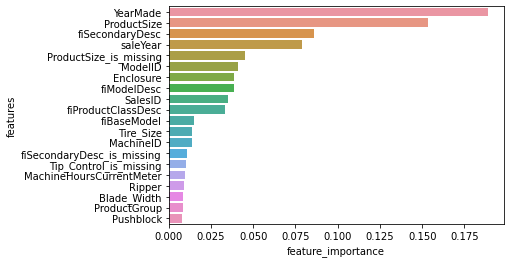

In [101]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [102]:
sum(ideal_model.feature_importances_)

1.0

In [103]:
df.ProductSize.isna().sum()

58694

In [104]:
df.ProductSize.value_counts()

Medium            18068
Large / Medium    10830
Large              5981
Small              3621
Mini               3427
Compact            1035
Name: ProductSize, dtype: int64

In [105]:
df.Turbocharged.value_counts()

None or Unspecified    25796
Yes                      990
Name: Turbocharged, dtype: int64

In [106]:
df.Thumb.value_counts()

None or Unspecified    15342
Manual                  1586
Hydraulic                888
Name: Thumb, dtype: int64